**Set environment**

In [2]:
suppressMessages(suppressWarnings(source("../run_config_project_sing.R")))
library(pheatmap)
show_env()

You are working on        Singularity: singularity_proj_encode_fcc 
BASE DIRECTORY (FD_BASE): /data/reddylab/Kuei 
REPO DIRECTORY (FD_REPO): /data/reddylab/Kuei/repo 
WORK DIRECTORY (FD_WORK): /data/reddylab/Kuei/work 
DATA DIRECTORY (FD_DATA): /data/reddylab/Kuei/data 

You are working with      ENCODE FCC 
PATH OF PROJECT (FD_PRJ): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC 
PROJECT RESULTS (FD_RES): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/results 
PROJECT SCRIPTS (FD_EXE): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/scripts 
PROJECT DATA    (FD_DAT): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/data 
PROJECT NOTE    (FD_NBK): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/notebooks 
PROJECT DOCS    (FD_DOC): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/docs 
PROJECT LOG     (FD_LOG): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/log 
PROJECT REF     (FD_REF): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/references 



## Import data

In [3]:
txt_fdiry = file.path(
    FD_RES, 
    "region_annotation", 
    "fcc_astarr_macs_input_overlap",
    "summary_v2"
)
txt_fname = "matrix.umap.cluster.cres_vote1_gcfilter.chipseq_full.fcc.tss.tsv"
txt_fpath = file.path(txt_fdiry, txt_fname)

dat = read_tsv(txt_fpath, show_col_types = FALSE)

dat_region_merge = dat
print(dim(dat))
head(dat, 3)

[1] 87610   540


Region,UMAP1,UMAP2,Cluster,ASTARR_A,WSTARR_A,LMPRA_A,TMPRA_A,ASTARR_R,WSTARR_R,⋯,ZNF778,ZNF780A,ZNF785,ZNF79,ZNF83,ZNF830,ZNF84,ZSCAN29,ZSCAN32,ZZZ3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1:10038-10405,-21.87767,-9.176196,39,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1:16025-16338,-12.15321,-12.879920,20,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1:115429-115969,-11.02704,-3.031374,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0


In [4]:
dat = dat_region_merge
vec = colnames(dat)
vec = vec[-c(1:4)]
vec_txt_feature = vec
print(length(vec))
head(vec)

[1] 536


[1] "ASTARR_A" "WSTARR_A" "LMPRA_A"  "TMPRA_A"  "ASTARR_R" "WSTARR_R"

In [5]:
vec_num_cluster = 0:10

In [6]:
lst_outer = list()
for (num_cluster in vec_num_cluster){
    
    lst_inner = list()
    for (txt_feature in vec_txt_feature){
        dat = dat_region_merge
        dat = dat %>% dplyr::mutate(Label_Cluster = as.integer(Cluster == num_cluster))
        dat[,"Label_Feature"] = dat[,txt_feature]

        dat = dat %>% dplyr::select(Label_Cluster, Label_Feature) 
        mat = table(dat$Label_Cluster, dat$Label_Feature)
        fit = fisher.test(mat)
        
        lst_inner[[txt_feature]] = fit
    }
    lst_outer[[as.character(num_cluster)]] = lst_inner
}

lst_fit_fisher = lst_outer

In [10]:
lst_outer = lst_fit_fisher

lst = lapply(lst_outer, function(lst_inner){
    lst = lapply(lst_inner, function(fit){
        res = c(fit$estimate, fit$p.value)
        names(res) = c("OddsRatio", "Pval")
    return(res)
    })
    
    dat = bind_rows(lst, .id = "Feature")
    return(dat)
})
dat = bind_rows(lst, .id = "Cluster")
dat = dat %>% 
    dplyr::mutate(Log2OR  = log2(OddsRatio)) %>%
    dplyr::mutate(PvalAdj = p.adjust(Pval, method = "BH")) %>%
    dplyr::mutate(NLog10P = -log10(PvalAdj))
                            
dat_res_fisher = dat
print(dim(dat))
head(dat)

[1] 5896    7


Cluster,Feature,OddsRatio,Pval,Log2OR,PvalAdj,NLog10P
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,ASTARR_A,3.3274674,0.000000e+00,1.73442451,0.000000e+00,Inf
0,WSTARR_A,0.8055076,1.389264e-28,-0.31202982,2.219811e-28,27.6536840
0,LMPRA_A,2.0273456,2.802289e-287,1.01959202,2.185489e-286,285.6604514
0,TMPRA_A,1.0151898,8.569083e-01,0.02174949,8.698917e-01,0.0605348
0,ASTARR_R,0.4075469,0.000000e+00,-1.29496214,0.000000e+00,Inf
0,WSTARR_R,0.7572300,2.982329e-08,-0.40119659,3.624033e-08,7.4408078


In [11]:
dat = dat_res_fisher
vec = dat$Log2OR
idx = is.infinite(vec)
vec = vec[!idx]
summary(vec)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-11.2330  -3.5474  -2.0724  -1.8661  -0.3393  13.5850 

In [12]:
dat = dat_res_fisher
vec = dat$NLog10P
idx = is.infinite(vec)
vec = vec[!idx]
summary(vec)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   10.82   38.43   65.80   98.94  322.08 

In [13]:
dat = dat_res_fisher
dat = dat %>% 
    dplyr::mutate(Log2OR = ifelse(is.infinite(Log2OR), 1000, Log2OR)) %>%
    dplyr::select(Cluster, Feature, Log2OR) %>% 
    tidyr::spread(Feature, Log2OR) %>%
    column_to_rownames(var = "Cluster")

head(dat)

,ADNP,AFF1,AGO1,ARHGAP35,ARID1B,ARID2,ARID3A,ARID3B,ARID4B,ARNT,⋯,ZNF778,ZNF780A,ZNF785,ZNF79,ZNF83,ZNF830,ZNF84,ZSCAN29,ZSCAN32,ZZZ3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2.3266975,1.8058205,-2.814338,0.9182434,5.5939839,-0.2365275,2.96247628,-0.2850484,-0.4648007,2.5979013,⋯,-0.4163935,-0.334690,0.1908035,1.338911,1.795705,-0.2629735,-1.008814,1.213023,0.2632714,-0.726981
1,1.1180789,2.9012459,4.685847,3.1998733,0.9895996,1.2862556,0.68056738,3.2434468,5.2567957,2.1709491,⋯,1.1246503,3.020322,0.3450165,1.077243,2.340352,4.0417486,4.582083,3.387505,2.7241544,4.631961
10,-0.9797064,-0.4313587,-2.341446,-1.6062211,-1.8860759,-3.2418665,-3.54934145,-1.7123594,-1.9973765,-2.0855986,⋯,-0.9932928,1000.000000,-0.9044524,-2.125195,-2.168925,-2.3187398,-3.060336,-2.579453,-2.8887301,-4.015653
2,-1.0778455,-1.9700493,-1.475214,-1.7220924,-2.3745210,3.6880653,0.01571403,-1.7795302,-1.6420303,-0.7904465,⋯,-0.4153630,-2.527362,-0.9490473,-2.591601,-2.783991,-1.4260581,-2.617579,-1.504520,-2.4702632,-1.082708
3,-0.1948442,-1.3764680,-3.607125,-2.1732387,1.6990723,-2.3526133,-0.44833138,-3.5717126,-2.7753741,-1.2323721,⋯,-1.3565461,-3.998620,-2.4635321,-1.449526,-1.018820,-2.0685838,-3.845178,-1.671714,-1.7546336,-3.282836
4,-1.4039115,-2.8190075,-3.445268,-3.4057612,-1.7602279,-4.3576066,-2.98494782,-3.9283903,-3.4134491,-3.1996126,⋯,-2.3236384,-3.350561,1000.0000000,-2.123416,-3.121181,-3.3026269,-5.620446,-2.341432,-3.8592753,-6.348569


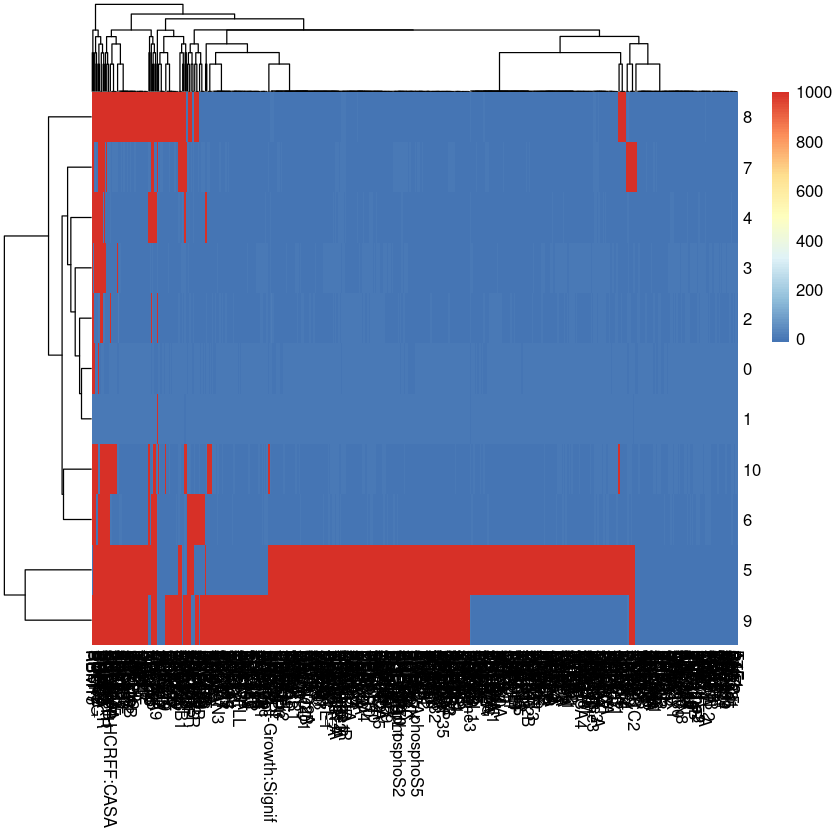

In [14]:
pheatmap(dat)

In [15]:
brewer.pal(n = 7, name = "RdYlBu")

[1] "#D73027" "#FC8D59" "#FEE090" "#FFFFBF" "#E0F3F8" "#91BFDB" "#4575B4"

In [16]:
vec_num_breaks = seq(-12, 12, by = 0.1)

vec = brewer.pal(n = 7, name = "RdYlBu")
vec = colorRampPalette(rev(vec))(length(vec_num_breaks))
vec_txt_colors = vec

In [17]:
vec = vec_txt_feature
idx = str_detect(vec, "p")
vec[idx]

[1] "POLR2AphosphoS2" "POLR2AphosphoS5"

In [18]:
vec = c("CTCF", "SMC3", "RAD21", "TSS", "POLR2A", "EP300", 
        'H3K27ac', 'H3K4me1', 'H3K4me2', 'H3K4me3')
mat = dat[, vec]
mat

,CTCF,SMC3,RAD21,TSS,POLR2A,EP300,H3K27ac,H3K4me1,H3K4me2,H3K4me3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,-1.1869710,-1.5552109,0.1077675,-3.154333,1.1115551,4.1532769,1.9867294,2.5911242,1.8955916,1.3749626
1,1.7847316,0.7737865,1.2017855,7.974646,5.3694268,1.1629380,4.5180853,2.7731879,6.3442408,6.4322235
10,-0.9001406,-1.2497371,-1.2043477,-4.166209,-2.0491108,-2.5560978,-1.1928644,-0.3661187,0.0562336,-0.5837631
2,11.6831711,7.4094156,11.8551609,-4.998479,-1.9440614,-1.9420804,-2.7858449,-0.9165555,-1.0533032,-1.4506636
3,-1.6045765,-2.7774545,-1.4393011,-4.754016,-1.4526000,0.2415534,0.7664672,1.0057427,0.3361924,-0.7392445
4,-1.7773567,-4.7816514,-2.3973990,-3.455948,-2.1882031,-3.1459829,-0.3193759,1.8424660,0.8519609,0.1259069
5,1000.0000000,1000.0000000,1000.0000000,1000.000000,1000.0000000,1000.0000000,-10.7543571,1000.0000000,-11.2329957,-10.6513273
6,-2.3873507,-5.1167120,-2.5221020,-3.421167,-0.6970058,-2.3282493,0.2748622,-1.1480585,0.9832403,0.8904412
7,-2.1738123,-4.7416284,-3.3727348,-3.932979,2.1784297,-5.8615402,-2.0462258,-0.7759330,-4.0318990,-4.1978314


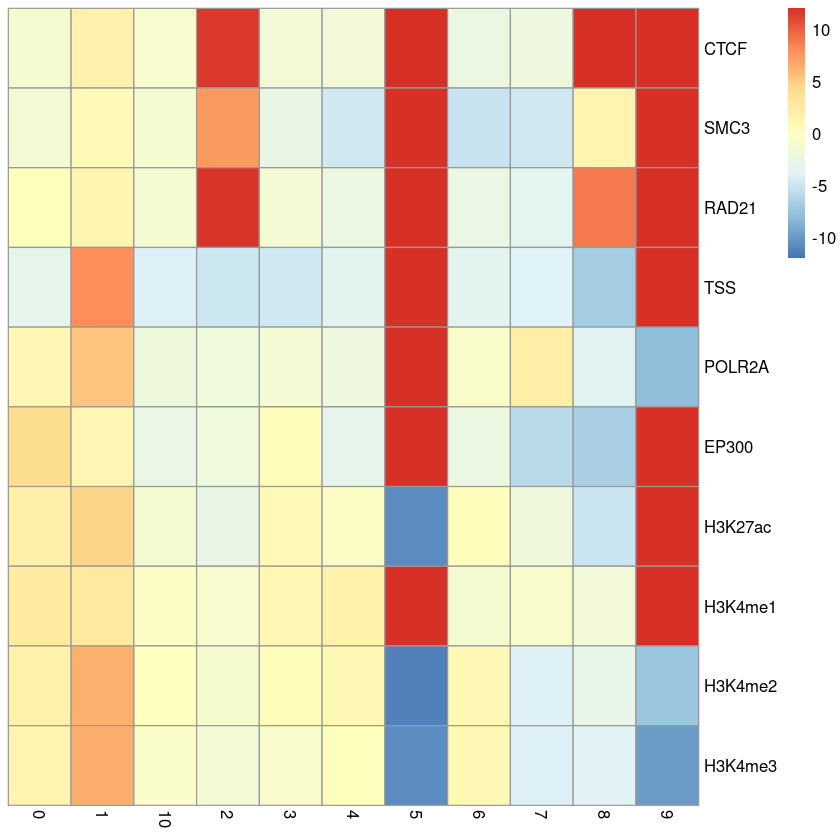

In [19]:
options(repr.plot.height = 7, repr.plot.width=7)
pheatmap(
    t(mat),
    color  = vec_txt_colors,
    breaks = vec_num_breaks,
    cluster_rows = FALSE,
    cluster_cols = FALSE
)

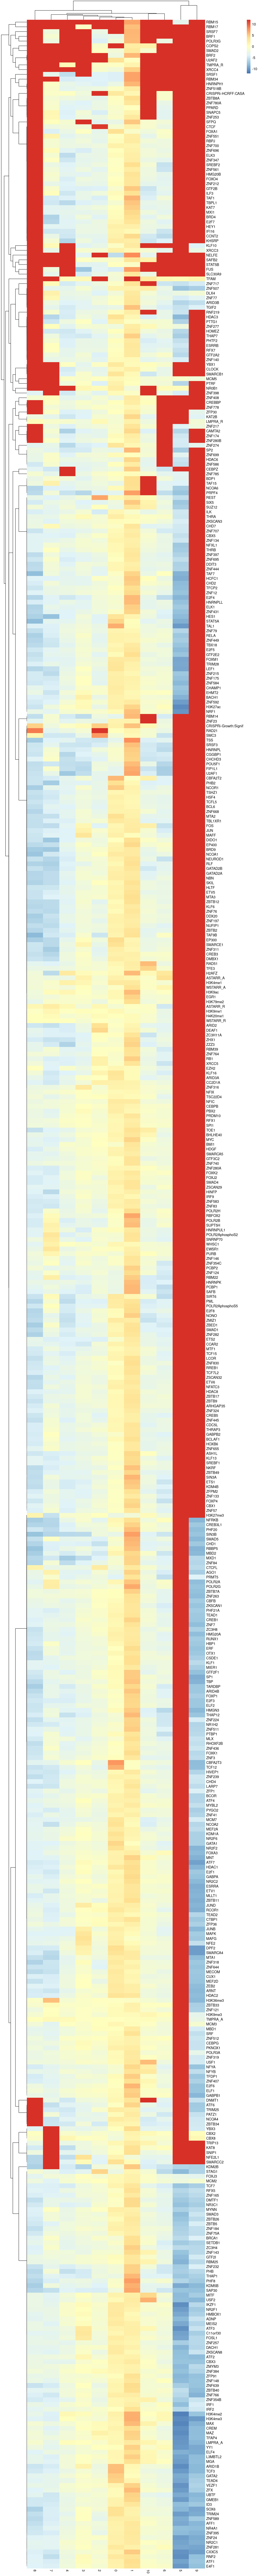

In [20]:
options(repr.plot.height = 100, repr.plot.width=10)
pheatmap(
    t(dat),
    color  = vec_txt_colors,
    breaks = vec_num_breaks,
    treeheight_row = 70
)

In [24]:
dat = dat_res_fisher
vec = dat$NLog10P
idx = is.infinite(vec)
vec = vec[!idx]
summary(vec)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   10.82   38.43   65.80   98.94  322.08 

In [25]:
dat = dat_res_fisher
dat = dat %>% 
    dplyr::mutate(NLog10P = ifelse(is.infinite(NLog10P), 1000, NLog10P)) %>%
    dplyr::select(Cluster, Feature, NLog10P) %>% 
    tidyr::spread(Feature, NLog10P) %>%
    column_to_rownames(var = "Cluster")

head(dat)

,ADNP,AFF1,AGO1,ARHGAP35,ARID1B,ARID2,ARID3A,ARID3B,ARID4B,ARNT,⋯,ZNF778,ZNF780A,ZNF785,ZNF79,ZNF83,ZNF830,ZNF84,ZSCAN29,ZSCAN32,ZZZ3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1000.000000,1000.000000,195.53418,27.450018,1000.00000,4.696913,1.000000e+03,2.534507,29.38715,1000.00000,⋯,0.4278476,1.339576,0.3945220,64.324965,1000.00000,4.680251,32.13041,230.75021,3.432652,10.80416
1,137.989998,1000.000000,1000.00000,1000.000000,258.18106,148.757447,4.702756e+01,1000.000000,1000.00000,1000.00000,⋯,2.9648546,131.347129,0.8726455,35.335951,1000.00000,1000.000000,1000.00000,1000.00000,1000.000000,1000.00000
10,9.274474,3.881994,17.72064,4.748899,84.64597,31.082951,4.395842e+01,5.508761,38.76417,41.78303,⋯,0.0000000,4.891464,0.3984408,6.736527,24.14644,18.194459,15.61543,42.52791,13.320832,10.70770
2,52.245379,210.341170,50.38532,25.460711,1000.00000,1000.000000,9.420355e-02,28.488667,152.97896,48.23675,⋯,0.2780661,14.973277,2.0649012,43.040880,165.71127,49.974492,71.19875,110.52669,59.693733,12.60925
3,2.145650,89.424748,98.02722,24.200996,1000.00000,84.405273,8.609060e+00,41.591800,209.66747,72.30503,⋯,0.8936763,15.323367,4.9383710,15.004754,30.16837,58.624345,70.00654,91.62149,28.112818,34.81285
4,37.247636,148.939166,61.74215,24.477416,184.10641,93.833879,9.305395e+01,28.997437,166.25999,160.98031,⋯,0.9965314,8.787086,5.6591065,16.142427,84.94073,62.077230,55.18025,92.81411,40.720193,31.72089


In [26]:
vec = c("CTCF", "SMC3", "RAD21", "TSS", "POLR2A", "EP300", 
        'H3K27ac', 'H3K4me1', 'H3K4me2', 'H3K4me3')
mat = dat[, vec]
mat

,CTCF,SMC3,RAD21,TSS,POLR2A,EP300,H3K27ac,H3K4me1,H3K4me2,H3K4me3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1000.00000,293.11995,3.927973,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
1,1000.00000,105.99703,1000.000000,1000.00000,1000.00000,305.578008,1000.000000,1000.000000,1000.000000,1000.000000
10,25.33805,24.92483,41.132007,62.70435,81.07852,87.723273,43.781933,6.653837,0.342959,12.203378
2,1000.00000,1000.00000,1000.000000,1000.00000,1000.00000,322.075766,1000.000000,177.470201,200.672819,289.801324
3,236.23896,263.32423,197.430770,256.20364,178.03317,7.151213,87.507098,142.871364,18.062131,64.250250
4,182.96169,265.10816,275.763306,134.54545,214.41280,266.506909,9.663001,276.254632,76.384944,1.973155
5,1000.00000,257.33868,1000.000000,160.52914,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
6,188.93615,186.20132,201.058765,90.95665,23.78448,130.801788,5.693385,93.818025,70.637040,55.737122
7,146.28010,156.30031,241.189699,88.01603,291.91672,238.234215,146.346533,39.009811,1000.000000,304.433675


In [38]:
vec_num_breaks = seq(0, 400, by = 0.1)

vec = brewer.pal(n = 7, name = "Reds")
vec = colorRampPalette(vec)(length(vec_num_breaks))
vec_txt_colors = vec

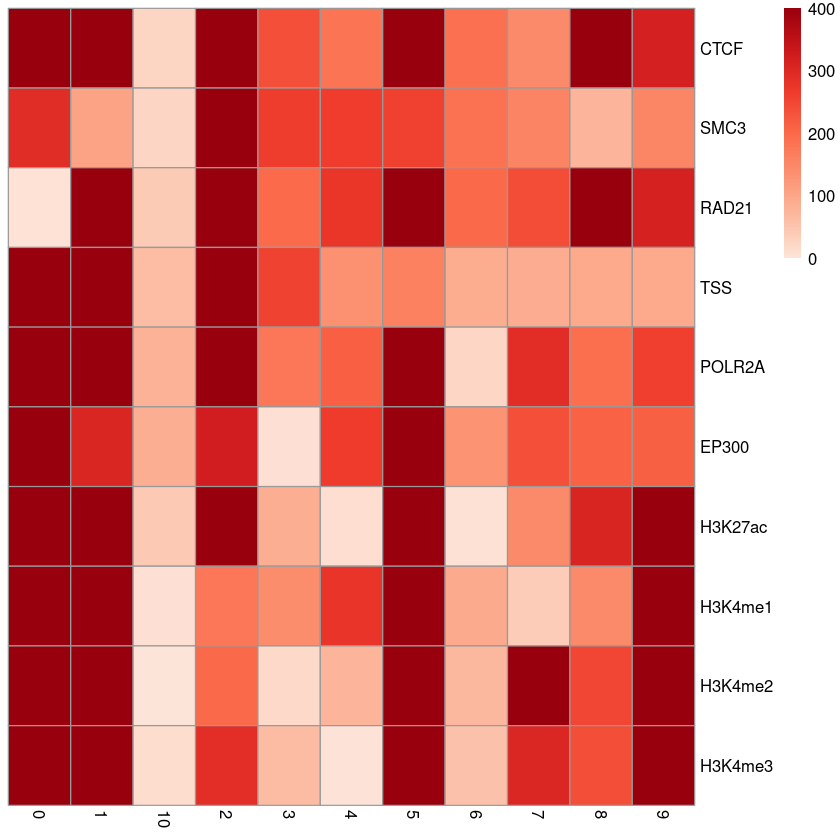

In [39]:
options(repr.plot.height = 7, repr.plot.width=7)
pheatmap(
    t(mat),
    color  = vec_txt_colors,
    breaks = vec_num_breaks,
    cluster_rows = FALSE,
    cluster_cols = FALSE
)

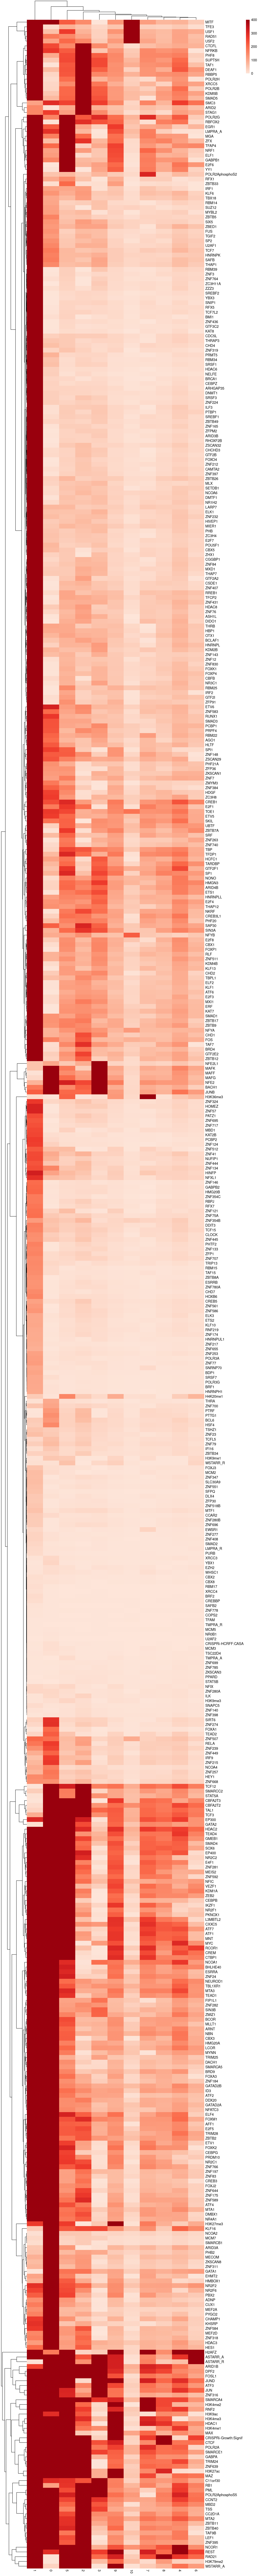

In [40]:
options(repr.plot.height = 100, repr.plot.width=10)
pheatmap(
    t(dat),
    color  = vec_txt_colors,
    breaks = vec_num_breaks,
    treeheight_row = 70
)